<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/2.3%20SNR%20Spread%20Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
## Install packages and initialize environment
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3' 

%matplotlib inline
import numpy
import pylab
import pycbc
from pycbc.waveform import get_td_waveform
import pycbc.noise
import pycbc.psd
from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [40]:
def create_waveform(mass1, mass2, resolution, frequencybound, distance):
  
  redshift = 1 + 72*distance/(299792.458-72*distance)
  
  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass2,
                                             delta_t=resolution/redshift,
                                             f_lower=frequencybound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(0, len(waveform)-1):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = numpy.array(waveform_amplitude)
  waveform_time = numpy.array(waveform_time)

  return waveform_amplitude, waveform_time
  

In [41]:
def determine_SNR(mass1, mass2, waveformmass1, waveformmass2, resolution, frequencybound, psdresolution, distance, noise, noisetime, graph = "F"):

  gwamp, gwtime = create_waveform(mass1, mass2, resolution, frequencybound, distance)

  # Generate the frequency series PSD

  samples = int(4096 / psdresolution) + 1

  designpsd = pycbc.psd.from_string(psd_name = noise,
                                         length = samples,
                                         delta_f = psdresolution, 
                                         low_freq_cutoff = frequencybound)

  # Generate [noisetime] seconds of Gaussian noise at [1/resolution] Hz

  timesamples = int(noisetime / resolution)
  gaussiannoise = pycbc.noise.gaussian.noise_from_psd(length = timesamples, 
                                                      delta_t = resolution,
                                                      psd = designpsd,
                                                      seed = None)
  
  # Resize GW signal to the length of the random noise sample

  timeshift = randint(0, len(gaussiannoise)-len(gwamp)) # Add a random timeshift
  gwamp = numpy.append([0] * timeshift, gwamp) # Append zeroes before the wave
  gwamp = numpy.append(gwamp, [0] * (len(gaussiannoise)-len(gwamp))) # Append zeroes after the wave 
  gwtime = gaussiannoise.sample_times

  ## Add the waveform to the generated noise

  gwnoise = gaussiannoise + gwamp

  ## Calculate the SNR time series 

  waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                               mass1=waveformmass1,
                                                               mass2=waveformmass2,
                                                               delta_t=resolution, 
                                                               f_lower=frequencybound)

  waveform_template.resize(len(gaussiannoise))
  waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)

  ## Calculate and plot the SNR
  
  psd = gwnoise.psd(4)
  psd = interpolate(psd, gwnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*gwnoise.sample_rate, low_frequency_cutoff=frequencybound)

  gwsnr = matched_filter(template=waveform_template,
                         data=gwnoise,
                         psd = psd,
                         low_frequency_cutoff=frequencybound)
  
  if graph == "T":
    pylab.figure()
    pylab.plot(gwsnr.sample_times, abs(gwsnr))

  gwsnrpeak = abs(gwsnr).numpy().argmax()
  gwsnrpeakvalue = gwsnr[gwsnrpeak]
  gwsnrpeaktime = gwsnr.sample_times[gwsnrpeak]

  print("A signal was found at {} s with SNR {}.".format(gwsnrpeaktime, abs(gwsnrpeakvalue)))
  print("The redshifted waveform was inserted at time {} s.".format(timeshift*resolution))

  return(abs(gwsnrpeakvalue))


In [ ]:
## Doesn't work for masses under 20 SM

distances = numpy.arange(50, 2050, 50)

snr20 = [0] * 40
snr30 = [0] * 40
snr40 = [0] * 40
snr50 = [0] * 40
snr60 = [0] * 40
snr70 = [0] * 40
snr80 = [0] * 40
snr90 = [0] * 40
snr100 = [0] * 40

snrlist = [snr20, snr30, snr40, snr50, snr60, snr70, snr80, snr90, snr100]
massarray = [20, 30, 40, 50, 60, 70, 80, 90, 100]

massindex = 0

for snr in snrlist:
  distanceindex = 0

  for distance in distances: 
    snrlist[massindex][distanceindex] = determine_SNR(mass1=massarray[massindex], mass2=massarray[massindex], 
                                               waveformmass1=massarray[massindex], waveformmass2=massarray[massindex],
                                               resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                               distance=distance, noise='aLIGODesignSensitivityP1200087', noisetime=32)
    
    distanceindex = distanceindex + 1

  massindex = massindex + 1

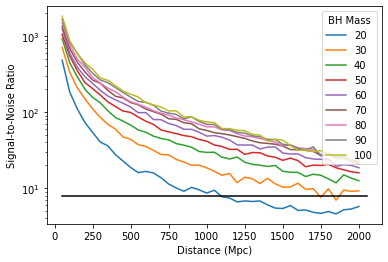

In [ ]:
index = 0

for snr in snrlist: 
  pylab.plot(distances, snrlist[index])
  index = index + 1

pylab.yscale('log')
x = [50, 2050]
y = [8, 8]
pylab.plot(x, y, color='black')
pylab.legend(labels=[20, 30, 40, 50, 60, 70, 80, 90, 100], title="BH Mass")
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-Noise Ratio")

A signal was found at 4.5498046875 s with SNR 313.7937155628426.
The redshifted waveform was inserted at time 3.6884765625 s.
A signal was found at 12.1513671875 s with SNR 331.86880504748893.
The redshifted waveform was inserted at time 11.2900390625 s.
A signal was found at 19.6875 s with SNR 335.96570867565396.
The redshifted waveform was inserted at time 18.826171875 s.
A signal was found at 29.21484375 s with SNR 338.1619516721612.
The redshifted waveform was inserted at time 28.353515625 s.
A signal was found at 21.5107421875 s with SNR 354.9846826280056.
The redshifted waveform was inserted at time 20.6494140625 s.
A signal was found at 5.921875 s with SNR 382.42210144972364.
The redshifted waveform was inserted at time 5.060546875 s.
A signal was found at 17.083984375 s with SNR 371.8951408833913.
The redshifted waveform was inserted at time 16.22265625 s.
A signal was found at 30.12109375 s with SNR 420.7755021420654.
The redshifted waveform was inserted at time 29.259765625 s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.158203125 s with SNR 665.6420858862198.
The redshifted waveform was inserted at time 2.298828125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.94140625 s with SNR 700.2484716537971.
The redshifted waveform was inserted at time 23.0830078125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 10.8974609375 s with SNR 688.3644681815232.
The redshifted waveform was inserted at time 10.0390625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 24.51953125 s with SNR 685.3310004455407.
The redshifted waveform was inserted at time 23.6611328125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 24.9248046875 s with SNR 665.7038452818846.
The redshifted waveform was inserted at time 24.06640625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.84765625 s with SNR 642.6715576177187.
The redshifted waveform was inserted at time 2.990234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 8.046875 s with SNR 620.903314823357.
The redshifted waveform was inserted at time 7.189453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 12.501953125 s with SNR 575.651379384471.
The redshifted waveform was inserted at time 11.64453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 31.3798828125 s with SNR 566.3053603664322.
The redshifted waveform was inserted at time 30.5224609375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 27.5751953125 s with SNR 521.5039061409178.
The redshifted waveform was inserted at time 26.7177734375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 5.947265625 s with SNR 522.5376738955397.
The redshifted waveform was inserted at time 5.08984375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 19.3212890625 s with SNR 488.1236219578985.
The redshifted waveform was inserted at time 18.4638671875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 15.67578125 s with SNR 486.02357140543336.
The redshifted waveform was inserted at time 14.8193359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.5302734375 s with SNR 466.41464716112347.
The redshifted waveform was inserted at time 25.673828125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 13.3740234375 s with SNR 477.14722156844897.
The redshifted waveform was inserted at time 12.517578125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.4140625 s with SNR 461.698317724548.
The redshifted waveform was inserted at time 13.5576171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 8.2236328125 s with SNR 472.71106630794395.
The redshifted waveform was inserted at time 7.3671875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 10.259765625 s with SNR 457.4102818739957.
The redshifted waveform was inserted at time 9.4033203125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.5849609375 s with SNR 438.77899436731167.
The redshifted waveform was inserted at time 2.728515625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 1.0263671875 s with SNR 463.73838527584127.
The redshifted waveform was inserted at time 0.169921875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 19.4912109375 s with SNR 572.6963161384391.
The redshifted waveform was inserted at time 18.990234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 9.17578125 s with SNR 611.4088273387532.
The redshifted waveform was inserted at time 8.6748046875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.94921875 s with SNR 626.2748979360618.
The redshifted waveform was inserted at time 14.44921875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.0 s with SNR 636.5677677368732.
The redshifted waveform was inserted at time 25.4990234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 5.802734375 s with SNR 653.0478636360037.
The redshifted waveform was inserted at time 5.302734375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.931640625 s with SNR 635.3843602644178.
The redshifted waveform was inserted at time 28.431640625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.4443359375 s with SNR 626.1213117390006.
The redshifted waveform was inserted at time 22.9443359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 22.95703125 s with SNR 681.0629503177935.
The redshifted waveform was inserted at time 22.45703125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 22.251953125 s with SNR 707.2227551653443.
The redshifted waveform was inserted at time 21.751953125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 25.302734375 s with SNR 723.4361434406724.
The redshifted waveform was inserted at time 24.802734375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 18.8564453125 s with SNR 719.1252627525803.
The redshifted waveform was inserted at time 18.3564453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 5.7548828125 s with SNR 749.5404592145813.
The redshifted waveform was inserted at time 5.2548828125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 29.43359375 s with SNR 748.7071327173365.
The redshifted waveform was inserted at time 28.9345703125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 30.3642578125 s with SNR 823.2788080063069.
The redshifted waveform was inserted at time 29.865234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 10.60546875 s with SNR 806.1751004453193.
The redshifted waveform was inserted at time 10.1064453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.7490234375 s with SNR 825.6013046390595.
The redshifted waveform was inserted at time 21.25 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 10.7216796875 s with SNR 817.3709324228909.
The redshifted waveform was inserted at time 10.22265625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 29.3369140625 s with SNR 838.5367521455071.
The redshifted waveform was inserted at time 28.837890625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 25.216796875 s with SNR 867.0210507076567.
The redshifted waveform was inserted at time 24.71875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 29.1845703125 s with SNR 877.1290918686593.
The redshifted waveform was inserted at time 28.6865234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 11.5830078125 s with SNR 859.308088310052.
The redshifted waveform was inserted at time 11.0849609375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 20.8720703125 s with SNR 866.9637990756045.
The redshifted waveform was inserted at time 20.3740234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 19.4130859375 s with SNR 873.9169785290205.
The redshifted waveform was inserted at time 18.9150390625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 13.8115234375 s with SNR 870.7001653805016.
The redshifted waveform was inserted at time 13.3134765625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 5.7861328125 s with SNR 859.3925456150669.
The redshifted waveform was inserted at time 5.2890625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.458984375 s with SNR 848.993665967563.
The redshifted waveform was inserted at time 25.9619140625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 12.09375 s with SNR 895.8581671289232.
The redshifted waveform was inserted at time 11.5966796875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 27.8876953125 s with SNR 861.5586883243237.
The redshifted waveform was inserted at time 27.390625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 12.3212890625 s with SNR 844.3720047895708.
The redshifted waveform was inserted at time 11.82421875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.798828125 s with SNR 809.353204223807.
The redshifted waveform was inserted at time 21.3017578125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 27.8369140625 s with SNR 826.6648298862698.
The redshifted waveform was inserted at time 27.3408203125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.3310546875 s with SNR 808.6149375148071.
The redshifted waveform was inserted at time 22.8349609375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 1.2568359375 s with SNR 856.8544463980264.
The redshifted waveform was inserted at time 0.7607421875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 15.9228515625 s with SNR 816.5792149349006.
The redshifted waveform was inserted at time 15.4267578125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 2.1787109375 s with SNR 790.2624605286807.
The redshifted waveform was inserted at time 1.6826171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 16.833984375 s with SNR 754.2822436520844.
The redshifted waveform was inserted at time 16.337890625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 7.0791015625 s with SNR 747.8770042844436.
The redshifted waveform was inserted at time 6.583984375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 13.447265625 s with SNR 728.9126604038801.
The redshifted waveform was inserted at time 12.9521484375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 15.9296875 s with SNR 770.5165902666655.
The redshifted waveform was inserted at time 15.4345703125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.873046875 s with SNR 724.9050105500055.
The redshifted waveform was inserted at time 14.3779296875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.0087890625 s with SNR 945.4438631764322.
The redshifted waveform was inserted at time 27.681640625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 19.640625 s with SNR 886.9174568735851.
The redshifted waveform was inserted at time 19.314453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.06640625 s with SNR 977.4598312802699.
The redshifted waveform was inserted at time 27.740234375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 7.91796875 s with SNR 961.1396788472146.
The redshifted waveform was inserted at time 7.591796875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 13.6416015625 s with SNR 945.4348963783959.
The redshifted waveform was inserted at time 13.3154296875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.7587890625 s with SNR 964.6605358815176.
The redshifted waveform was inserted at time 23.4326171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.6630859375 s with SNR 953.8767264434936.
The redshifted waveform was inserted at time 21.3369140625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 22.955078125 s with SNR 952.3118744550981.
The redshifted waveform was inserted at time 22.62890625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 18.1015625 s with SNR 1012.2754197461481.
The redshifted waveform was inserted at time 17.7763671875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 15.962890625 s with SNR 1011.7874487843752.
The redshifted waveform was inserted at time 15.6376953125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 17.2373046875 s with SNR 1001.8186782088732.
The redshifted waveform was inserted at time 16.912109375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.1259765625 s with SNR 1060.4547379458209.
The redshifted waveform was inserted at time 25.80078125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 18.4091796875 s with SNR 1009.381128594445.
The redshifted waveform was inserted at time 18.083984375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 1.056640625 s with SNR 1074.4958887252417.
The redshifted waveform was inserted at time 0.7314453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.509765625 s with SNR 1010.9092738759124.
The redshifted waveform was inserted at time 26.1845703125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 31.431640625 s with SNR 1073.1918359763465.
The redshifted waveform was inserted at time 31.1064453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 12.142578125 s with SNR 1063.119751597795.
The redshifted waveform was inserted at time 11.818359375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 2.62109375 s with SNR 1034.7789791368953.
The redshifted waveform was inserted at time 2.296875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.71875 s with SNR 1027.7654812911185.
The redshifted waveform was inserted at time 23.39453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.498046875 s with SNR 1027.6393538110424.
The redshifted waveform was inserted at time 3.173828125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 26.3583984375 s with SNR 1020.6198568273702.
The redshifted waveform was inserted at time 26.0341796875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 15.0234375 s with SNR 1021.6443138694759.
The redshifted waveform was inserted at time 14.69921875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 10.453125 s with SNR 1044.1309345261163.
The redshifted waveform was inserted at time 10.12890625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 12.4404296875 s with SNR 1032.9106827922774.
The redshifted waveform was inserted at time 12.1171875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 19.7646484375 s with SNR 1048.5306896314962.
The redshifted waveform was inserted at time 19.44140625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.1669921875 s with SNR 1022.2481078489243.
The redshifted waveform was inserted at time 20.84375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 21.1796875 s with SNR 1032.7609925806719.
The redshifted waveform was inserted at time 20.8564453125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 19.869140625 s with SNR 1048.9634300347975.
The redshifted waveform was inserted at time 19.5458984375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 11.177734375 s with SNR 1036.3928063395142.
The redshifted waveform was inserted at time 10.8544921875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.88671875 s with SNR 1038.868402970024.
The redshifted waveform was inserted at time 14.5634765625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 29.7529296875 s with SNR 998.6534179595245.
The redshifted waveform was inserted at time 29.4296875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 3.23046875 s with SNR 1029.52224155404.
The redshifted waveform was inserted at time 2.908203125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 16.83984375 s with SNR 1032.9969891363783.
The redshifted waveform was inserted at time 16.517578125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 7.3203125 s with SNR 1019.7916824480388.
The redshifted waveform was inserted at time 6.998046875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 23.7509765625 s with SNR 1029.4220789943497.
The redshifted waveform was inserted at time 23.4287109375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 15.4052734375 s with SNR 1007.8301670633656.
The redshifted waveform was inserted at time 15.0830078125 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 6.7138671875 s with SNR 1004.5784960407942.
The redshifted waveform was inserted at time 6.3916015625 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 8.0361328125 s with SNR 1034.2976383718062.
The redshifted waveform was inserted at time 7.7138671875 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 14.5390625 s with SNR 986.2283490522666.
The redshifted waveform was inserted at time 14.2177734375 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


A signal was found at 28.1044921875 s with SNR 1050.3658418184984.
The redshifted waveform was inserted at time 27.783203125 s.


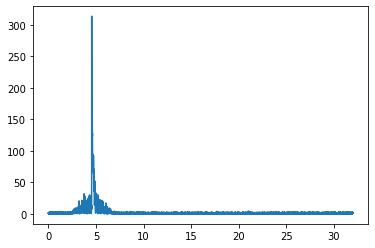

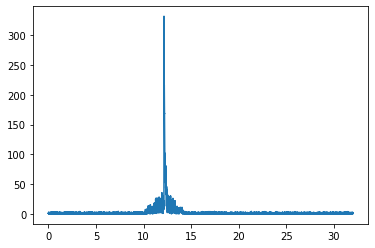

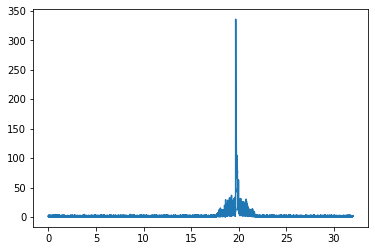

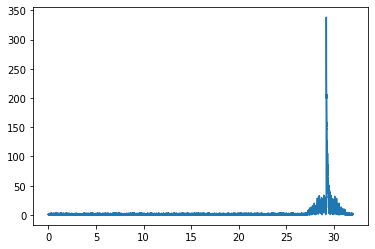

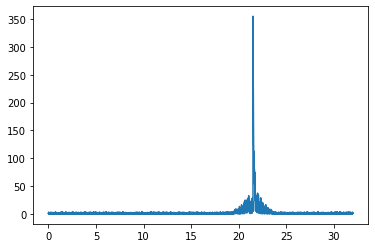

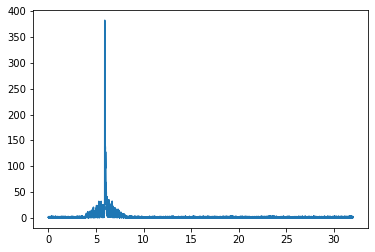

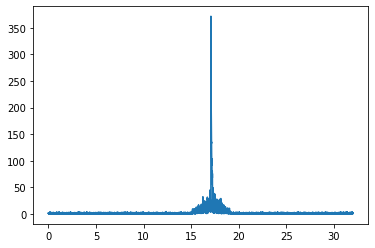

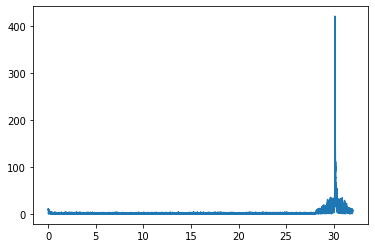

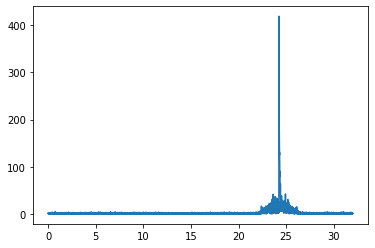

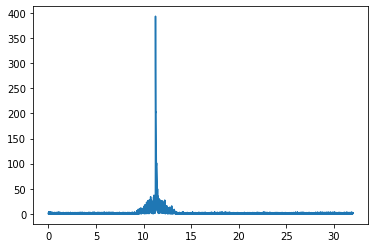

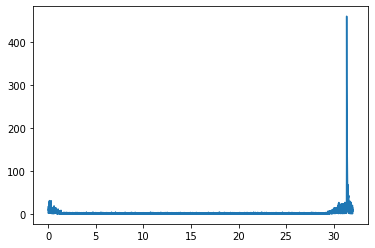

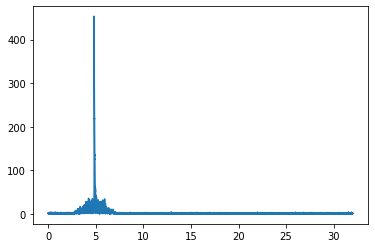

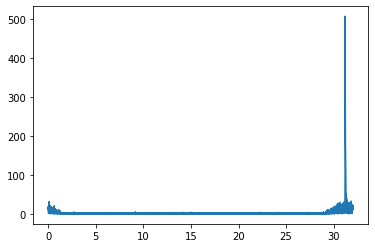

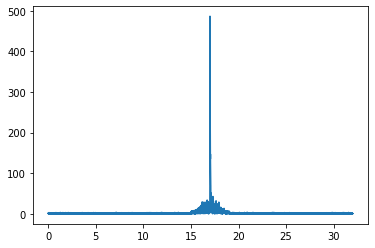

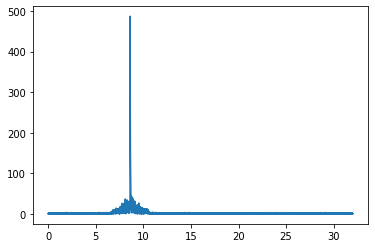

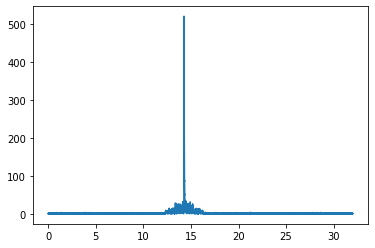

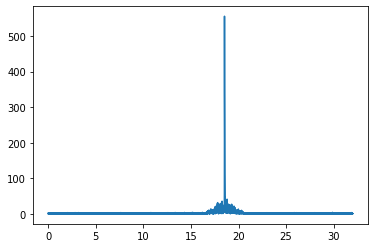

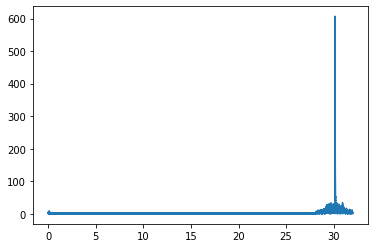

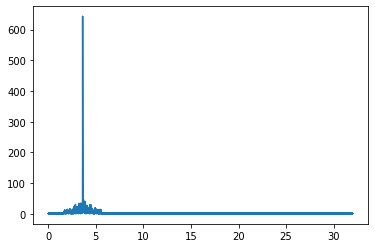

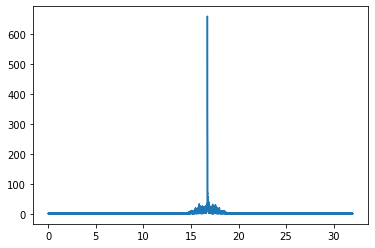

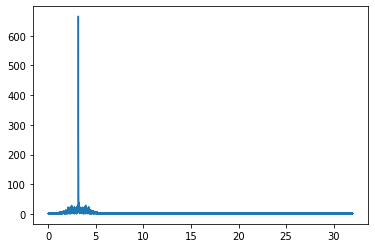

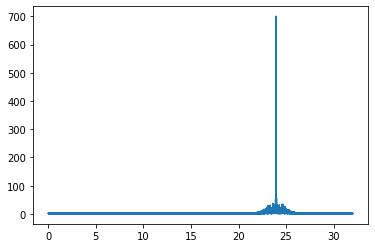

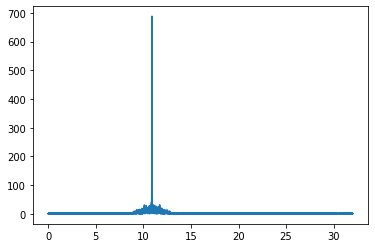

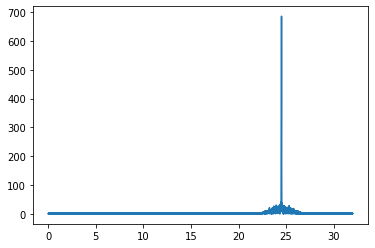

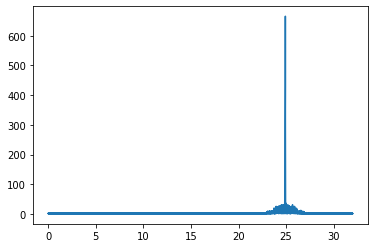

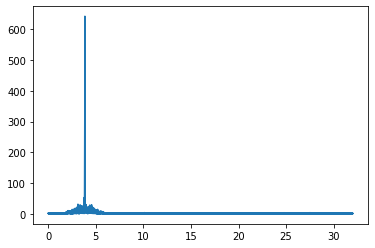

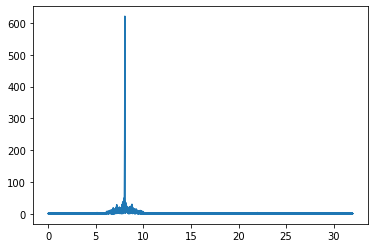

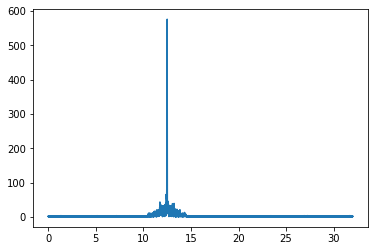

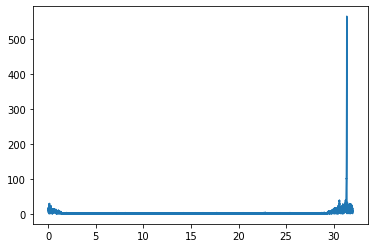

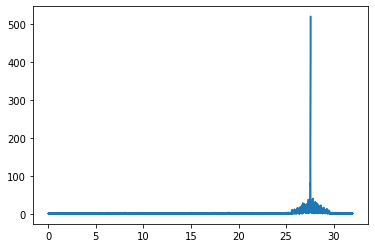

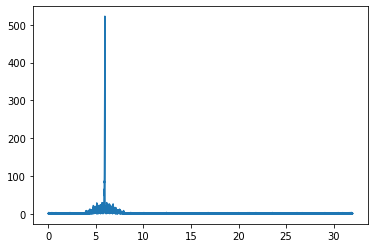

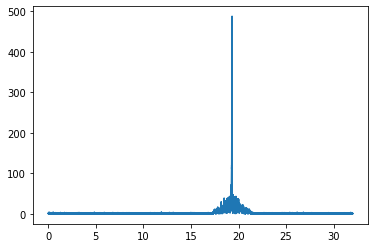

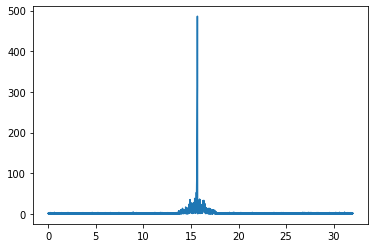

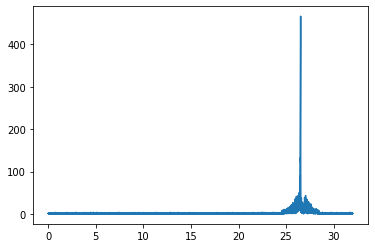

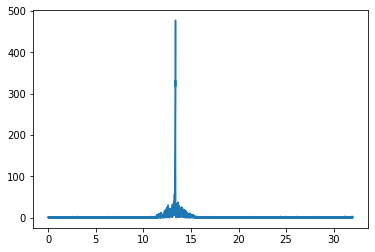

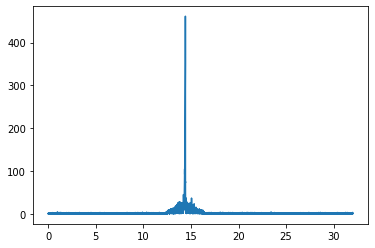

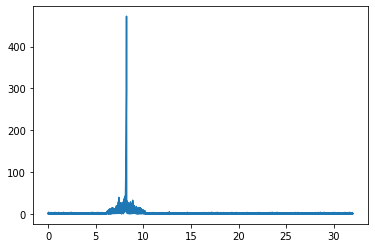

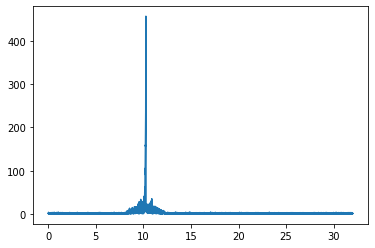

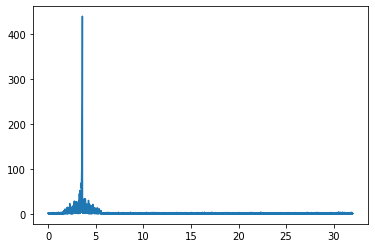

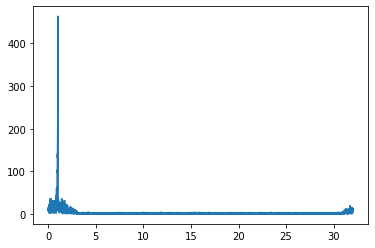

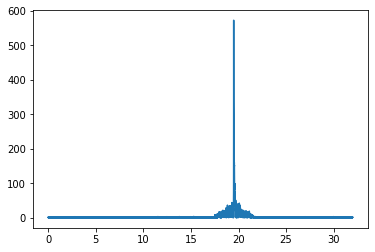

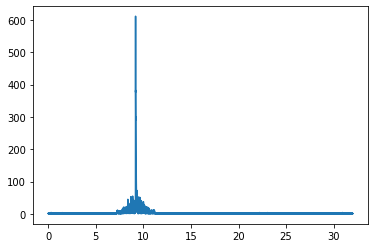

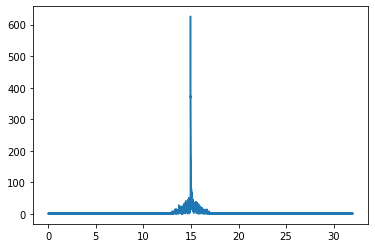

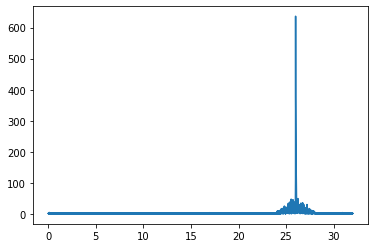

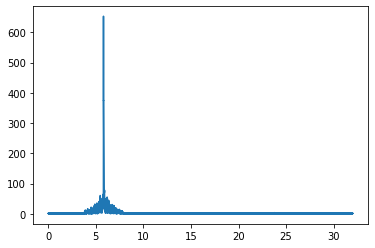

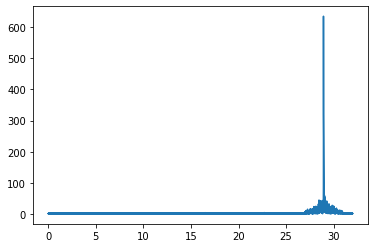

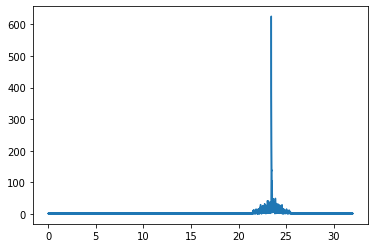

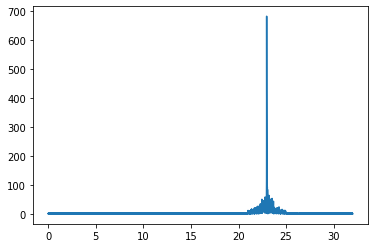

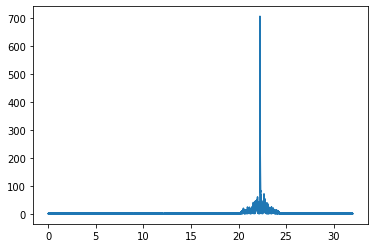

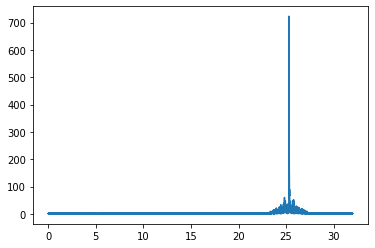

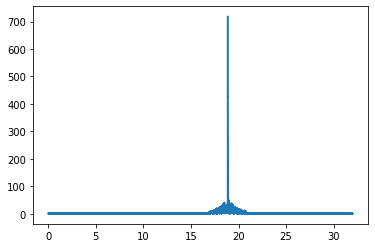

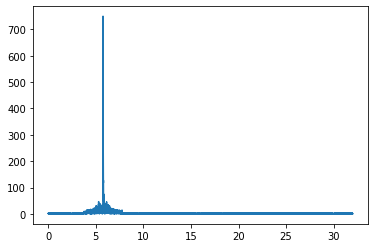

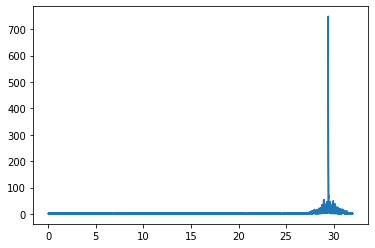

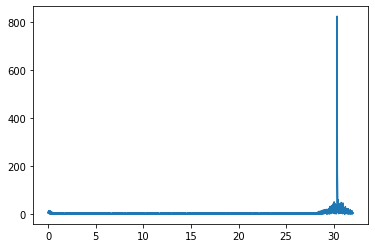

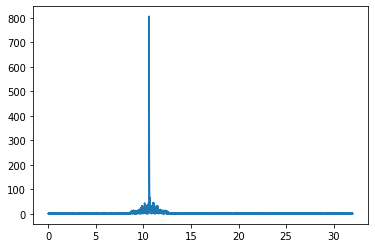

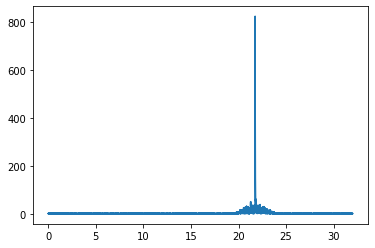

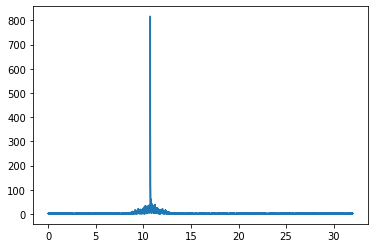

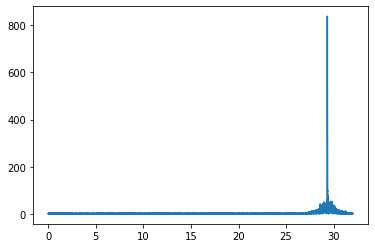

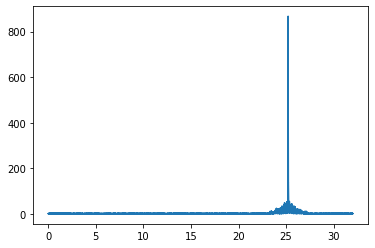

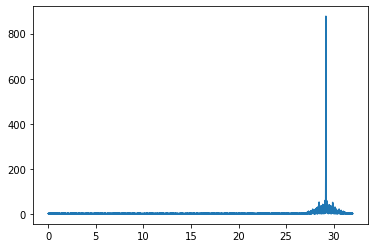

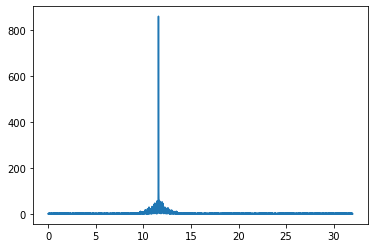

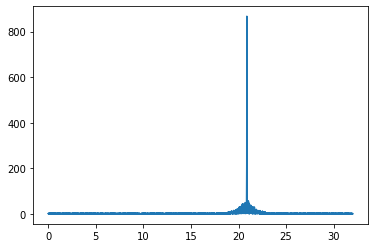

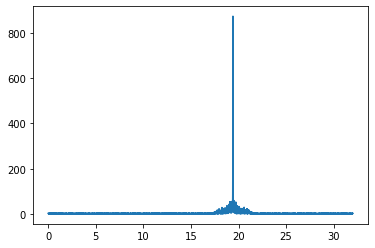

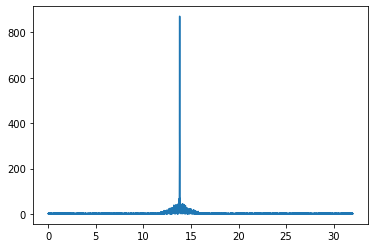

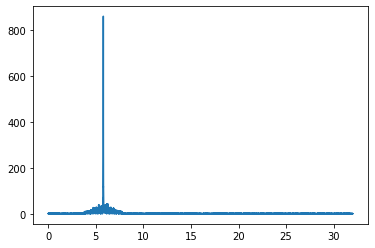

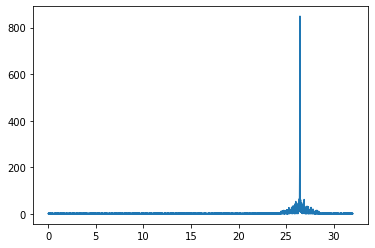

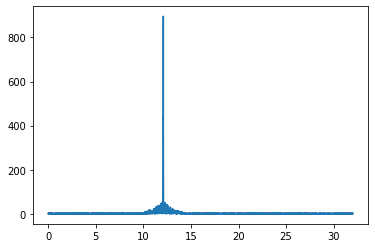

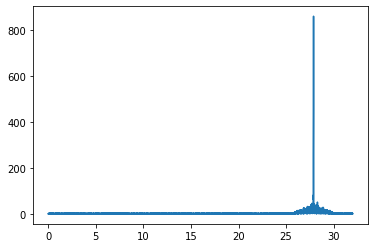

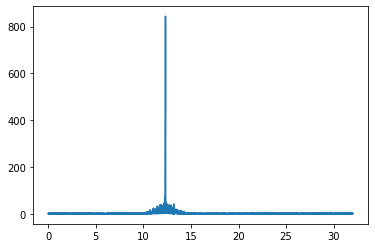

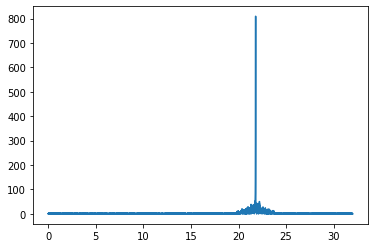

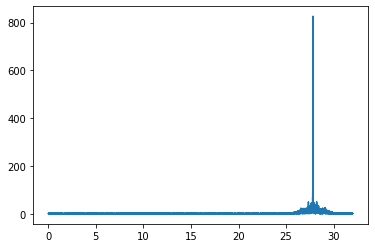

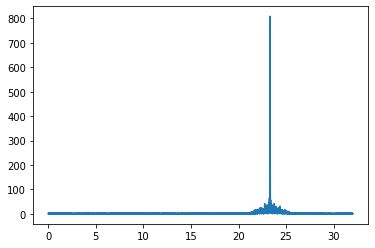

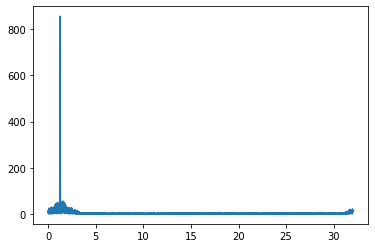

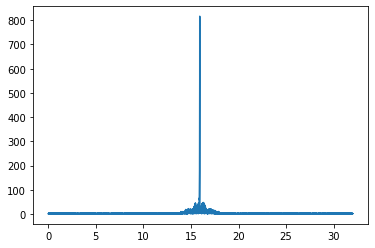

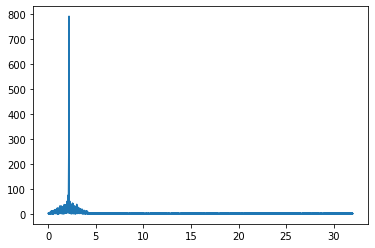

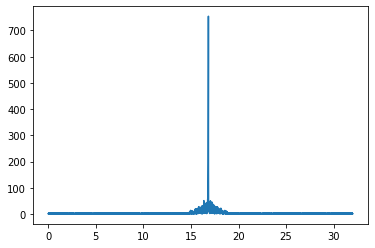

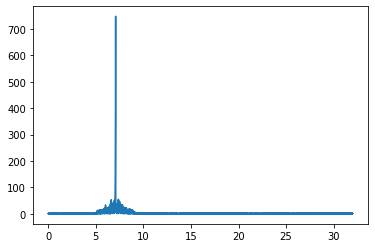

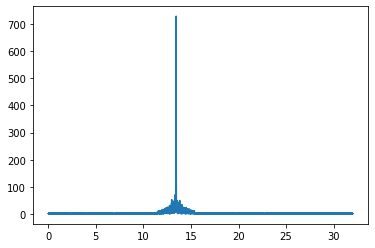

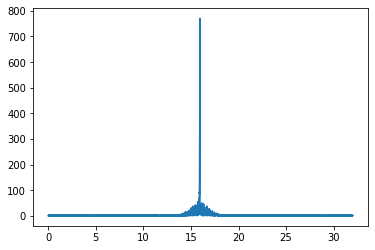

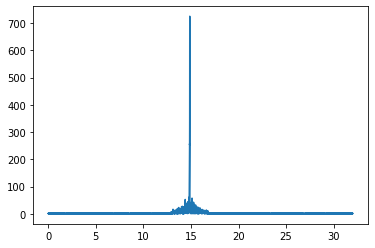

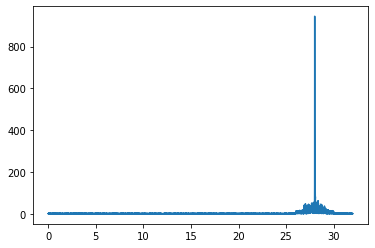

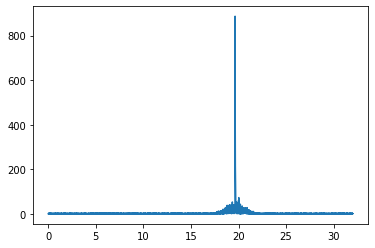

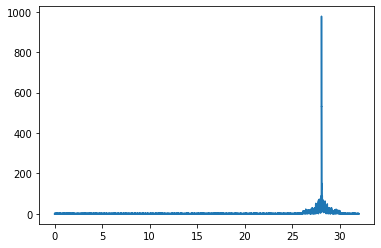

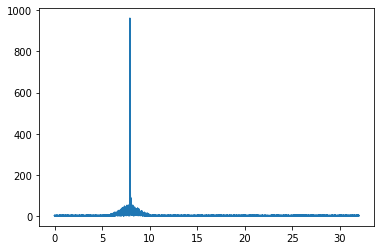

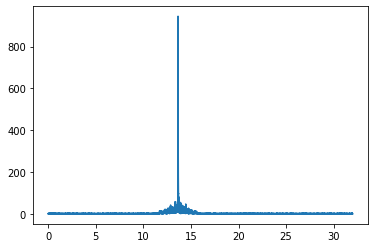

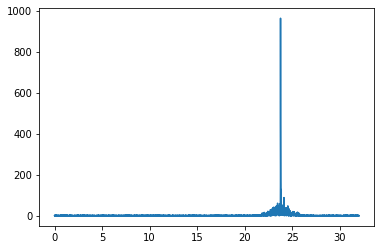

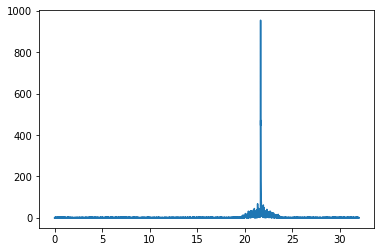

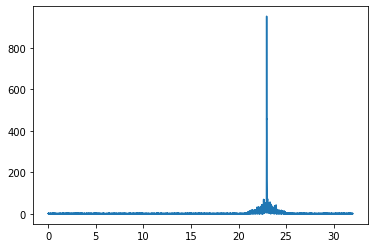

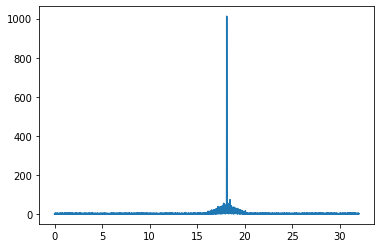

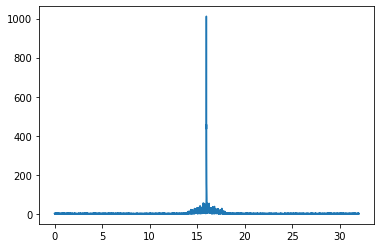

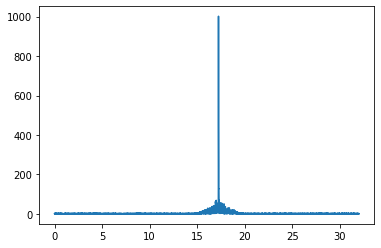

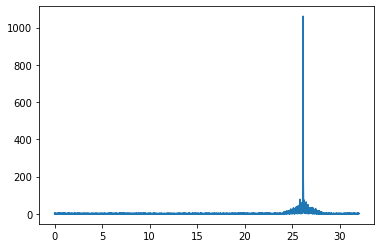

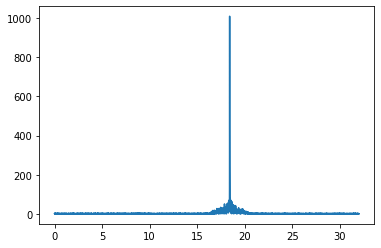

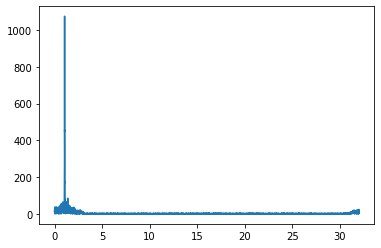

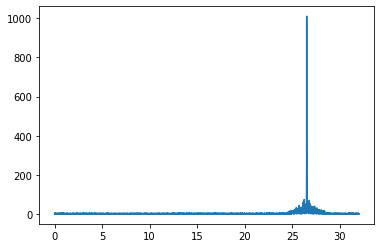

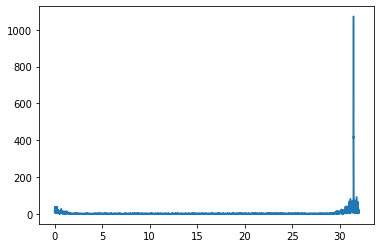

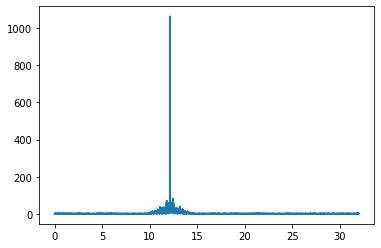

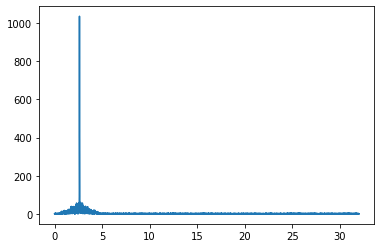

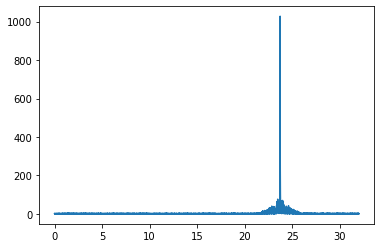

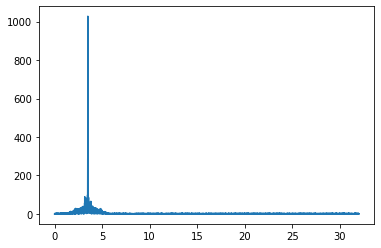

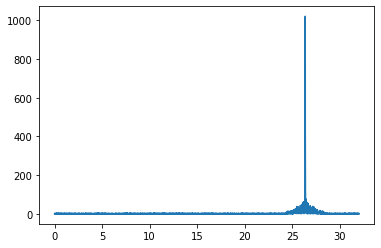

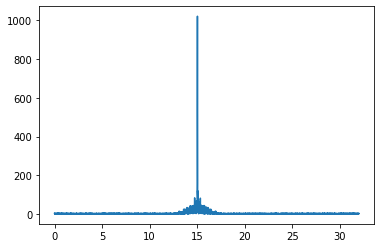

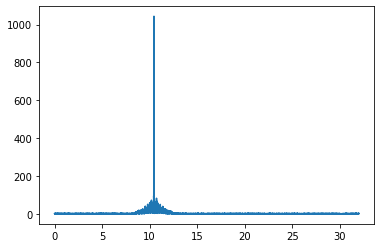

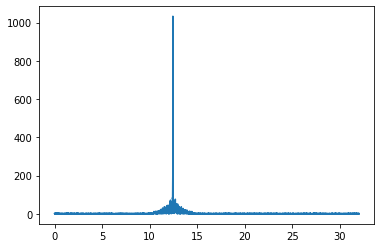

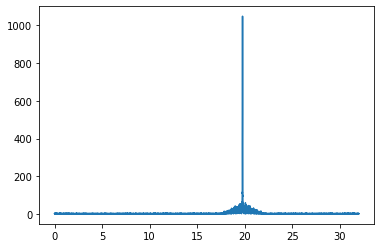

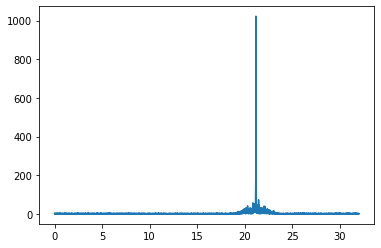

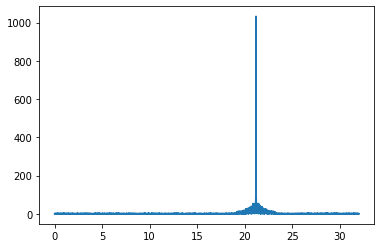

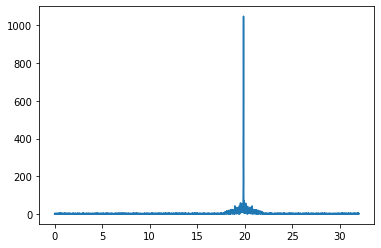

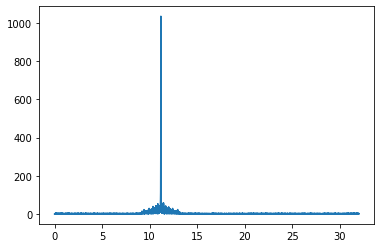

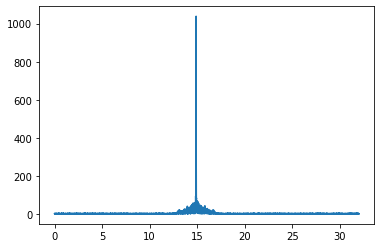

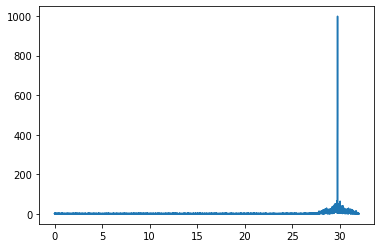

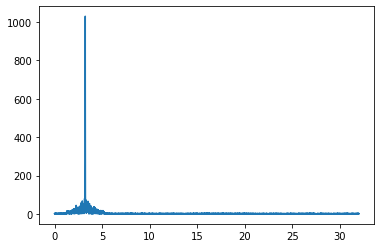

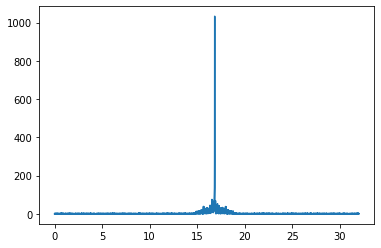

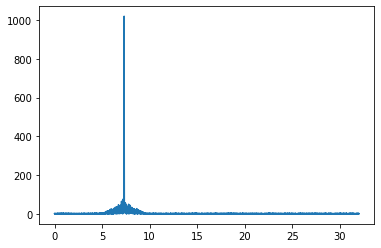

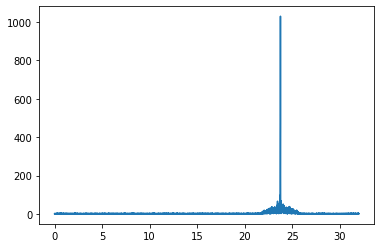

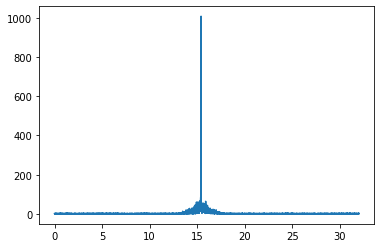

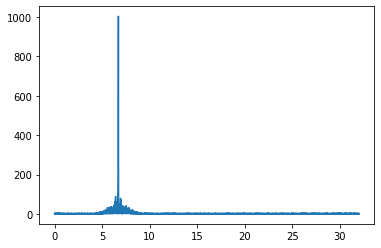

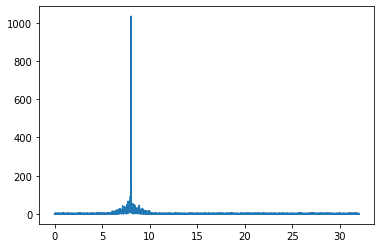

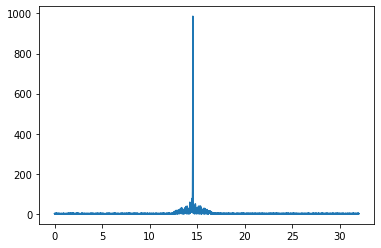

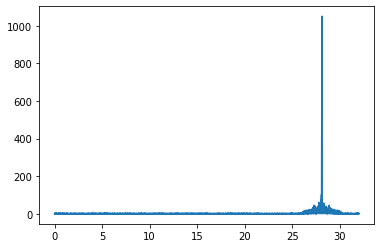

In [ ]:
## Look at the impact of imprecise waveforms for m = 30, 40, 50

masses30 = numpy.arange(25, 35, 0.25)
masses40 = numpy.arange(35, 45, 0.25)
masses50 = numpy.arange(45, 55, 0.25)

snr30d500 = [0] * 40
snr40d500 = [0] * 40
snr50d500 = [0] * 40

for index in range((len(masses30))):
  snr30d500[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=masses30[index], waveformmass2=masses30[index],
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=50, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
for index in range((len(masses40))):
  snr40d500[index] = determine_SNR(mass1=40, mass2=40,
                                      waveformmass1=masses40[index], waveformmass2=masses40[index],
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=50, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
for index in range((len(masses50))):
  snr50d500[index] = determine_SNR(mass1=50, mass2=50,
                                      waveformmass1=masses50[index], waveformmass2=masses50[index],
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=50, noise='aLIGODesignSensitivityP1200087', noisetime=32)

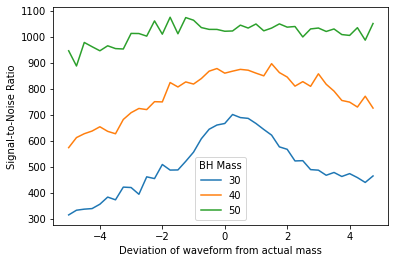

In [ ]:
masses = numpy.arange(-5, 5, 0.25)

pylab.plot(masses, snr30d500)
pylab.plot(masses, snr40d500)
pylab.plot(masses, snr50d500)
pylab.xlabel("Deviation of waveform from actual mass")
pylab.ylabel("Signal-to-Noise Ratio")
pylab.legend(labels=[30, 40, 50], title="BH Mass")


In [ ]:
snr30 = numpy.zeros( (20, 20) )

for row in range(len(snr30)):
  for column in range(len(snr30[row])):

    mass1 = 25 + 0.5*row
    mass2 = 25 + 0.5*column

    snr30[row][column] = determine_SNR(mass1=mass1, mass2=mass2,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)

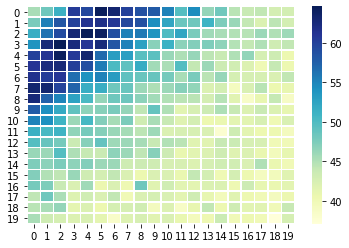

In [ ]:
import seaborn as sns

sns.heatmap(snr30, linewidths=0.5, cmap="YlGnBu")


In [ ]:
## Different noise curves

distances = numpy.arange(100, 2100, 100)

snr30design = [0] * 20
snr30low = [0] * 20
snr30high = [0] * 20

for index in range((len(snr30design))):
  snr30design[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=distances[index], noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
for index in range((len(snr30low))):
  snr30low[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=distances[index], noise='aLIGOEarlyLowSensitivityP1200087', noisetime=32)
  
for index in range((len(snr30high))):
  snr30high[index] = determine_SNR(mass1=30, mass2=30,
                                      waveformmass1=30, waveformmass2=30,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=distances[index], noise='aLIGOEarlyHighSensitivityP1200087', noisetime=32)


Text(0, 0.5, 'Signal-to-Noise Ratio')

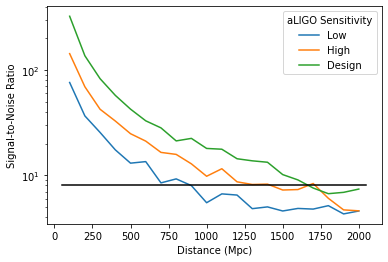

In [ ]:
pylab.plot(distances, snr30low)
pylab.plot(distances, snr30high)
pylab.plot(distances, snr30design)

pylab.yscale('log')
x = [50, 2050]
y = [8, 8]
pylab.plot(x, y, color='black')
pylab.legend(labels=['Low', 'High', 'Design'], title="aLIGO Sensitivity")
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-Noise Ratio")



In [ ]:
snr40d500 = numpy.zeros( (40, 40) )

for row in range(len(snr40d500)):
  for column in range(len(snr40d500[row])):

    mass1 = 35 + 0.25*row
    mass2 = 35 + 0.25*column

    snr40d500[row][column] = determine_SNR(mass1=mass1, mass2=mass2,
                                      waveformmass1=40, waveformmass2=40,
                                      resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                      distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)

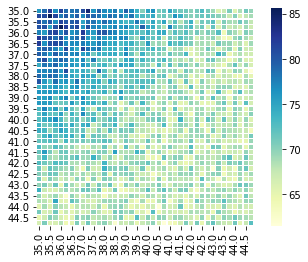

In [56]:
import seaborn as sns
import pandas as pd

names = numpy.arange(35, 45, 0.25)
snr40d500 = pd.DataFrame(snr40d500, columns=names, index=names)

sns.heatmap(snr40d500, linewidths=0.2, cmap="YlGnBu", square="True")


In [ ]:
snr30test = [0] * 500
snr40test = [0] * 500
snr50test = [0] * 500

for index in range(500):
  snr30test[index] = determine_SNR(mass1=30, mass2=30,
                                   waveformmass1=30, waveformmass2=30,
                                   resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                   distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  snr40test[index] = determine_SNR(mass1=40, mass2=40,
                                   waveformmass1=40, waveformmass2=40,
                                   resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                   distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  snr50test[index] = determine_SNR(mass1=50, mass2=50,
                                   waveformmass1=50, waveformmass2=50,
                                   resolution=1.0/1024, frequencybound=20, psdresolution=1.0/16,
                                   distance=500, noise='aLIGODesignSensitivityP1200087', noisetime=32)
  
  print(index)

The average SNR for m=30, d=500 is 44.17599373892851 and the standard deviation is 1.608421026770784 with a skewness of 0.07557095567950556.
The average SNR for m=40, d=500 is 68.48876759348883 and the standard deviation is 2.1145601891074444 with a skewness of 0.004834258084507885.
The average SNR for m=50, d=500 is 92.87204818200728 and the standard deviation is 2.8053772564203183 with a skewness of 0.01637309649692844.


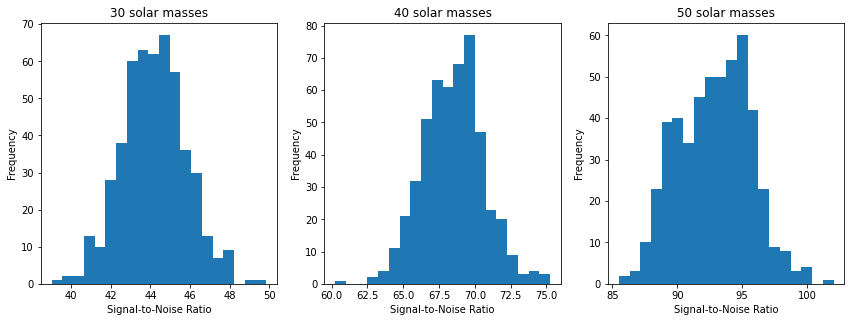

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import skew

fig = plt.figure()

plt.subplot(1,3,1)
plt.hist(snr30test, bins=20)
plt.ylabel("Frequency")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("30 solar masses")

plt.subplot(1,3,2)
plt.hist(snr40test, bins=20)
plt.ylabel("Frequency")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("40 solar masses")

plt.subplot(1,3,3)
plt.hist(snr50test, bins=20)
plt.ylabel("Frequency")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("50 solar masses")

fig.set_figheight(4.8)
fig.set_figwidth(14.4)

fig.show()

print("The average SNR for m=30, d=500 is {} and the standard deviation is {} with a skewness of {}.".format(numpy.mean(snr30test), numpy.std(snr30test), skew(snr30test)))
print("The average SNR for m=40, d=500 is {} and the standard deviation is {} with a skewness of {}.".format(numpy.mean(snr40test), numpy.std(snr40test), skew(snr40test)))
print("The average SNR for m=50, d=500 is {} and the standard deviation is {} with a skewness of {}.".format(numpy.mean(snr50test), numpy.std(snr50test), skew(snr50test)))

In [ ]:
## Determine SNR of pure noise (design sensitivity)

designpsd = pycbc.psd.from_string(psd_name = 'aLIGODesignSensitivityP1200087',
                                  length = int(4096 * 16) + 1, 
                                  delta_f = 1.0/16, 
                                  low_freq_cutoff = 10)

import random 

designnoisesnr = [0] * 1000

waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                             mass1=30, mass2=30, delta_t=1.0/4096, f_lower=10)
waveform_template.resize(32*4096)
waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)


for index in range(1000):

  seed = random.randint(0, 100000)
  designnoise = pycbc.noise.noise_from_psd(length = 32*4096,
                                           delta_t = 1.0/4096,
                                           psd = designpsd,
                                           seed = seed)
  
  psd = designnoise.psd(4)
  psd = interpolate(psd, designnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*designnoise.sample_rate, low_frequency_cutoff=10)

  snr = matched_filter(template=waveform_template, data=designnoise, psd=psd, low_frequency_cutoff=10)

  snrpeak = abs(snr).numpy().argmax()
  snrpeakvalue = snr[snrpeak]

  designnoisesnr[index] = abs(snrpeakvalue)
  print(index, designnoisesnr[index])


## Determine SNR of pure noise (low sensitivity)

designpsd = pycbc.psd.from_string(psd_name = 'aLIGOEarlyLowSensitivityP1200087',
                                  length = int(4096 * 16) + 1, 
                                  delta_f = 1.0/16, 
                                  low_freq_cutoff = 10)

import random 

noisesnr = [0] * 1000

waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                             mass1=30, mass2=30, delta_t=1.0/4096, f_lower=10)
waveform_template.resize(32*4096)
waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)


for index in range(1000):

  seed = random.randint(0, 100000)
  designnoise = pycbc.noise.noise_from_psd(length = 32*4096,
                                           delta_t = 1.0/4096,
                                           psd = designpsd,
                                           seed = seed)
  
  psd = designnoise.psd(4)
  psd = interpolate(psd, designnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*designnoise.sample_rate, low_frequency_cutoff=10)

  snr = matched_filter(template=waveform_template, data=designnoise, psd=psd, low_frequency_cutoff=10)

  snrpeak = abs(snr).numpy().argmax()
  snrpeakvalue = snr[snrpeak]

  lownoisesnr[index] = abs(snrpeakvalue)
  print(index, lownoisesnr[index])


## Determine SNR of pure noise (high sensitivity)

designpsd = pycbc.psd.from_string(psd_name = 'aLIGOEarlyHighSensitivityP1200087',
                                  length = int(4096 * 16) + 1, 
                                  delta_f = 1.0/16, 
                                  low_freq_cutoff = 10)

import random 

noisesnr = [0] * 1000

waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                             mass1=30, mass2=30, delta_t=1.0/4096, f_lower=10)
waveform_template.resize(32*4096)
waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)


for index in range(1000):

  seed = random.randint(0, 100000)
  designnoise = pycbc.noise.noise_from_psd(length = 32*4096,
                                           delta_t = 1.0/4096,
                                           psd = designpsd,
                                           seed = seed)
  
  psd = designnoise.psd(4)
  psd = interpolate(psd, designnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*designnoise.sample_rate, low_frequency_cutoff=10)

  snr = matched_filter(template=waveform_template, data=designnoise, psd=psd, low_frequency_cutoff=10)

  snrpeak = abs(snr).numpy().argmax()
  snrpeakvalue = snr[snrpeak]

  highnoisesnr[index] = abs(snrpeakvalue)
  print(index, highnoisesnr[index])

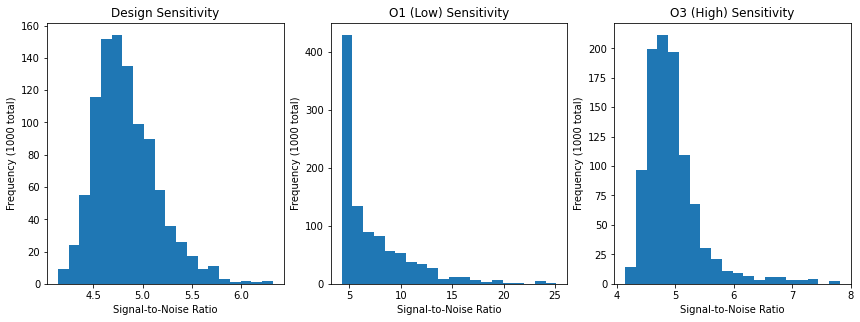

The average SNR for design sensitivity is 4.835620193288221, the standard deviation is 0.3200134933078223, and the skewness is 0.8942099327674431.
The average SNR for low sensitivity is 7.264708112549044, the standard deviation is 3.4440859352006314, and the skewness is 1.8856120283658462.
The average SNR for high sensitivity is 4.950500810319626, the standard deviation is 0.4941020541765346, and the skewness is 2.1888191277031277.


In [52]:
fig = plt.figure()

plt.subplot(1,3,1)
plt.hist(designnoisesnr, bins=20)
plt.ylabel("Frequency (1000 total)")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("Design Sensitivity")

plt.subplot(1,3,2)
plt.hist(lownoisesnr, bins=20)
plt.ylabel("Frequency (1000 total)")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("O1 (Low) Sensitivity")

plt.subplot(1,3,3)
plt.hist(highnoisesnr, bins=20)
plt.ylabel("Frequency (1000 total)")
plt.xlabel("Signal-to-Noise Ratio")
plt.title("O3 (High) Sensitivity")

fig.set_figheight(4.8)
fig.set_figwidth(14.4)

plt.show()


print("The average SNR for design sensitivity is {}, the standard deviation is {}, and the skewness is {}.".format(numpy.mean(designnoisesnr), numpy.std(designnoisesnr), skew(designnoisesnr)))
print("The average SNR for low sensitivity is {}, the standard deviation is {}, and the skewness is {}.".format(numpy.mean(lownoisesnr), numpy.std(lownoisesnr), skew(lownoisesnr)))
print("The average SNR for high sensitivity is {}, the standard deviation is {}, and the skewness is {}.".format(numpy.mean(highnoisesnr), numpy.std(highnoisesnr), skew(highnoisesnr)))